In [9]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    data_location = "https://raw.githubusercontent.com/ourownstory/neural_prophet/master/energy/"
else:
    data_location = "../"

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-zkj393ut
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-zkj393ut
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-cp37-none-any.whl size=58262 sha256=eeca077adb5339c1a14d0246ad6ece771fb6b775e0c77e09e66108c1d420d9a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxje3yin/wheels/5a/29/25/58347b486c135e3aaa41f629bace08cfb3e92d08c65d2b4acf
Successfully built neuralprophet


# Example on PV forecasting dataset

In this first section, we will train a 1-step ahead forecaster on solar irradiance data (that can be a proxy for solar PV production). We can train this forecaster considering the privious 24 steps and letting neuralprophet automatically chooses the other parameters.


The paramters that we can modify are for the AR sparsity and the neural network architecture

The training will occur on 80% of the data, reserving the last 20% for the validation.




In [11]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")
files = ['SanFrancisco_PV_GHI.csv', 'SanFrancisco_Hospital.csv']
raw = pd.read_csv(data_location + files[0])
df=pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

df.head(3)

,ds,y
0,2015-01-01 01:00:00,0
1,2015-01-01 02:00:00,0
2,2015-01-01 03:00:00,0


In [30]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    #num_hidden_layers = 2,
    #d_hidden=20,
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73


  0%|          | 0/297 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.45E-02, min: 3.07E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.61E-01
Epoch[73/73]: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s, SmoothL1Loss=0.00193, MAE=31.3, MSE=2.94e+3, RegLoss=0.000183]


In [31]:
df_train, df_val = m.split_df(df, freq='H',valid_p=0.2)
m.test(df_val)

INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE      MSE
1         0.001 28.062 2122.507


,SmoothL1Loss,MAE,MSE
0,0.001396,28.061516,2122.506974


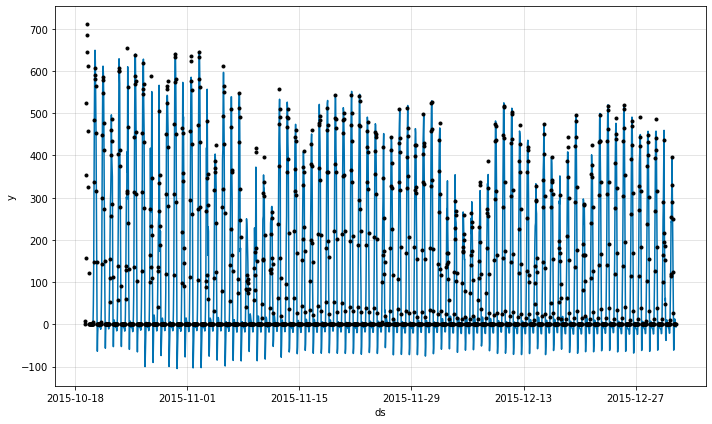

In [32]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

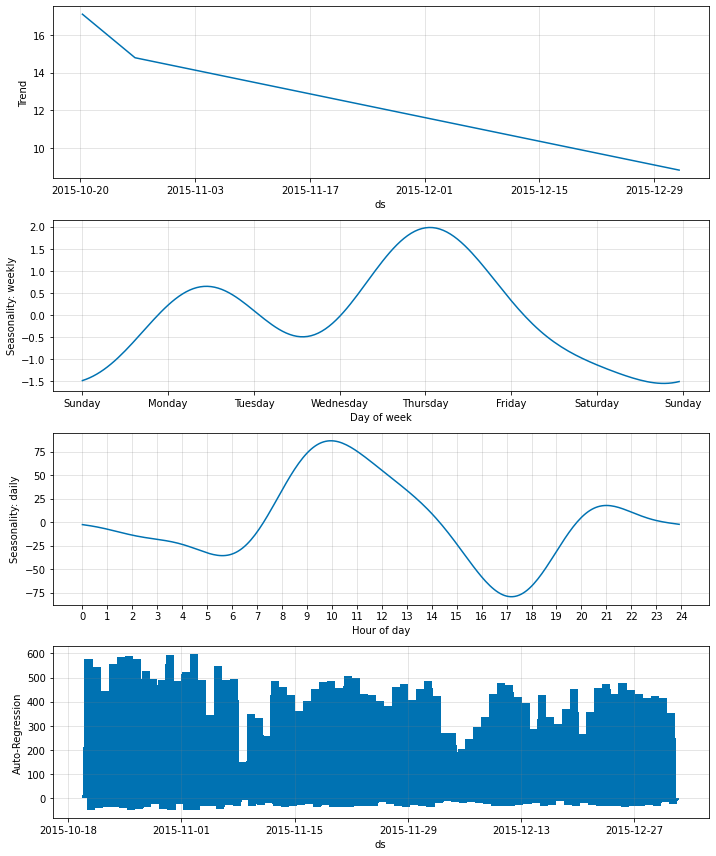

In [33]:
fig_comp = m.plot_components(forecast)


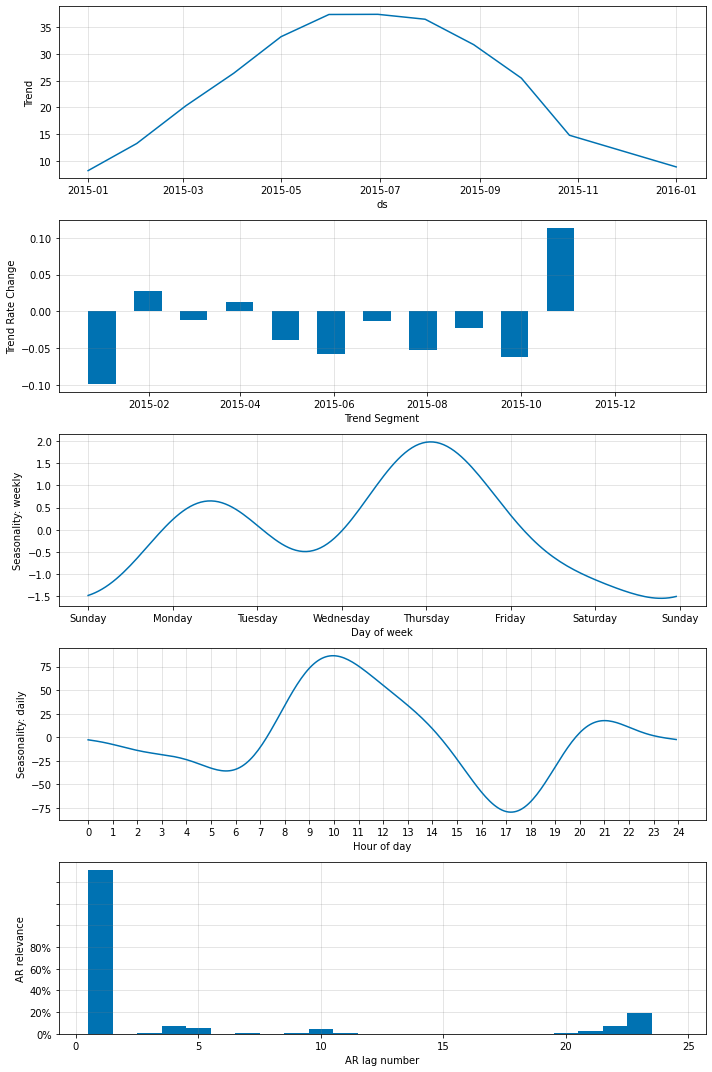

In [34]:
fig_param = m.plot_parameters()


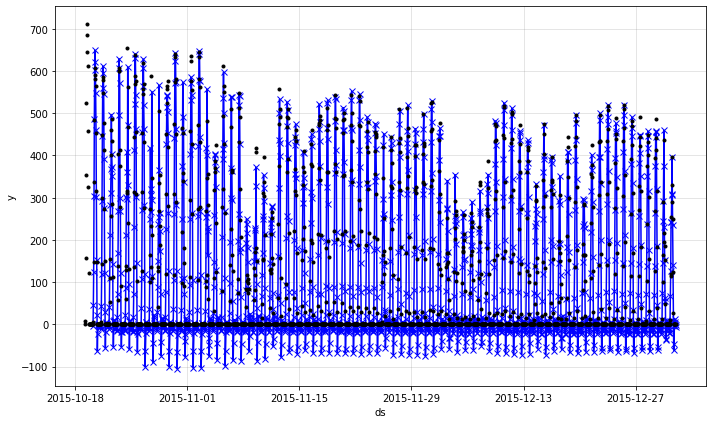

In [35]:
fig_fit = m.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)


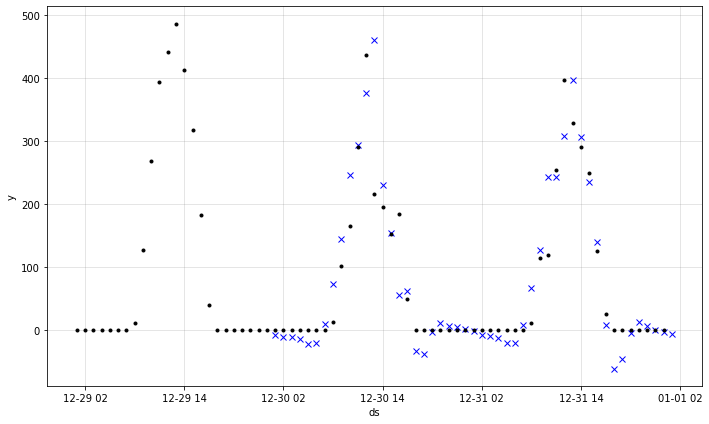

In [36]:
fig_prediction = m.plot_last_forecast(forecast, include_previous_forecasts=48)


There is something to consider here, if we consider a neural network with at least one hidden layer. For a high enough learning rate (probably > 0.1), the gradient seems to vanish and forces the AR net output to 0.  

From below, we can see that the forecast output has a strange behavior. it looks like the output is exactly the sum of the weekly, daily seasonlality with trend. With no noise and changes at all.

In [37]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate = 0.1
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73
Epoch[73/73]: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s, SmoothL1Loss=0.0097, MAE=96, MSE=1.48e+4, RegLoss=4.86e-5]


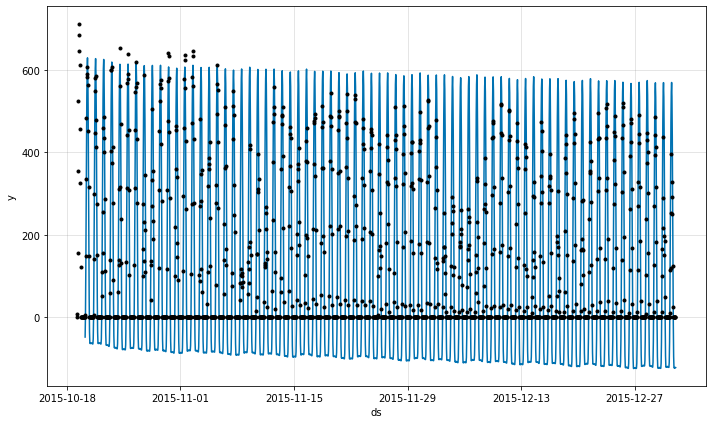

In [38]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

An easy fix is to set the learning rate at a low enough value.

In [39]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate = 0.001
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73
Epoch[73/73]: 100%|██████████| 73/73 [00:54<00:00,  1.34it/s, SmoothL1Loss=0.00158, MAE=26.3, MSE=2.41e+3, RegLoss=0.000998]


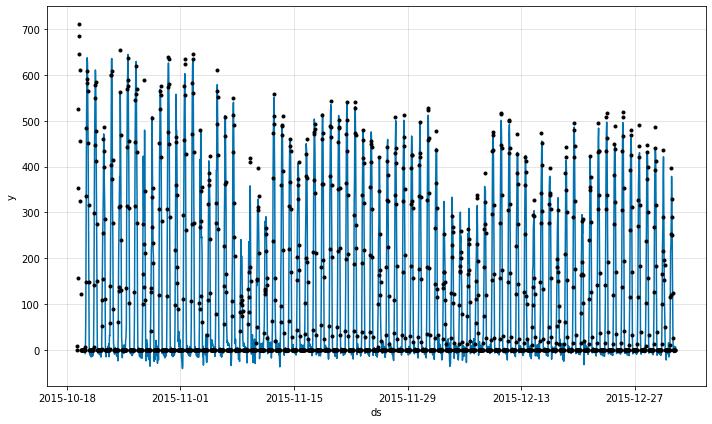

In [40]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

## Example on load forecasting

We can train a forecaster on another commom energy problem. In this, case we are training a 1-step ahead forecaster to predict the electricity consumption of a building. We use a similar NeuralProphet model as we used for the PV forecasting.

In [41]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")
files = ['SanFrancisco_PV_GHI.csv', 'SanFrancisco_Hospital.csv']
raw = pd.read_csv(data_location + files[1])

df=pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

df.head(3)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338


In [42]:
print(raw)

      Electricity:Facility [kW](Hourly)
0                            778.007969
1                            776.241750
2                            779.357338
3                            778.737196
4                            787.835835
...                                 ...
8755                         845.563081
8756                         827.530521
8757                         829.256300
8758                         813.937205
8759                         815.588584

[8760 rows x 1 columns]


In [57]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate=0.001
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73
Epoch[73/73]: 100%|██████████| 73/73 [00:54<00:00,  1.33it/s, SmoothL1Loss=0.00049, MAE=13.4, MSE=354, RegLoss=0.000921]


In [58]:
df_train, df_val = m.split_df(df, freq='H',valid_p=0.2)
m.test(df_val)

INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE     MSE
1         0.001 13.704 374.965


,SmoothL1Loss,MAE,MSE
0,0.00052,13.703728,374.965097


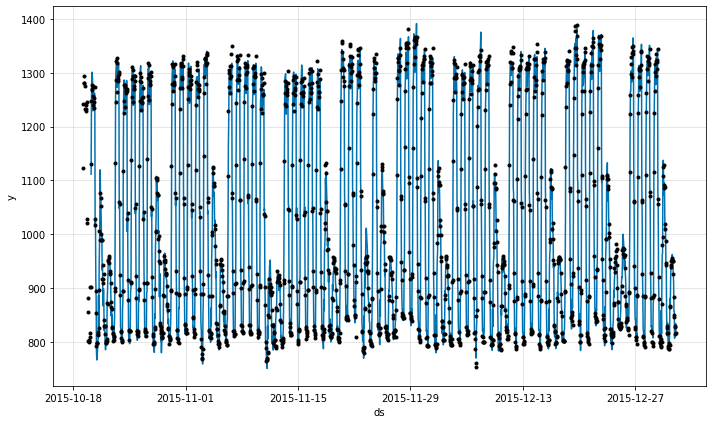

In [59]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

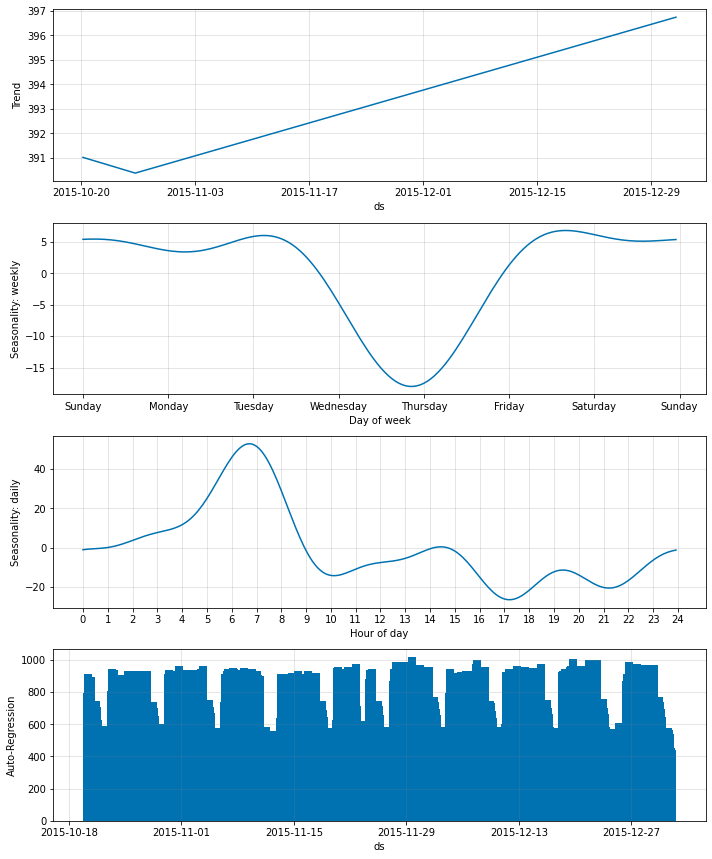

In [60]:
fig_comp = m.plot_components(forecast)


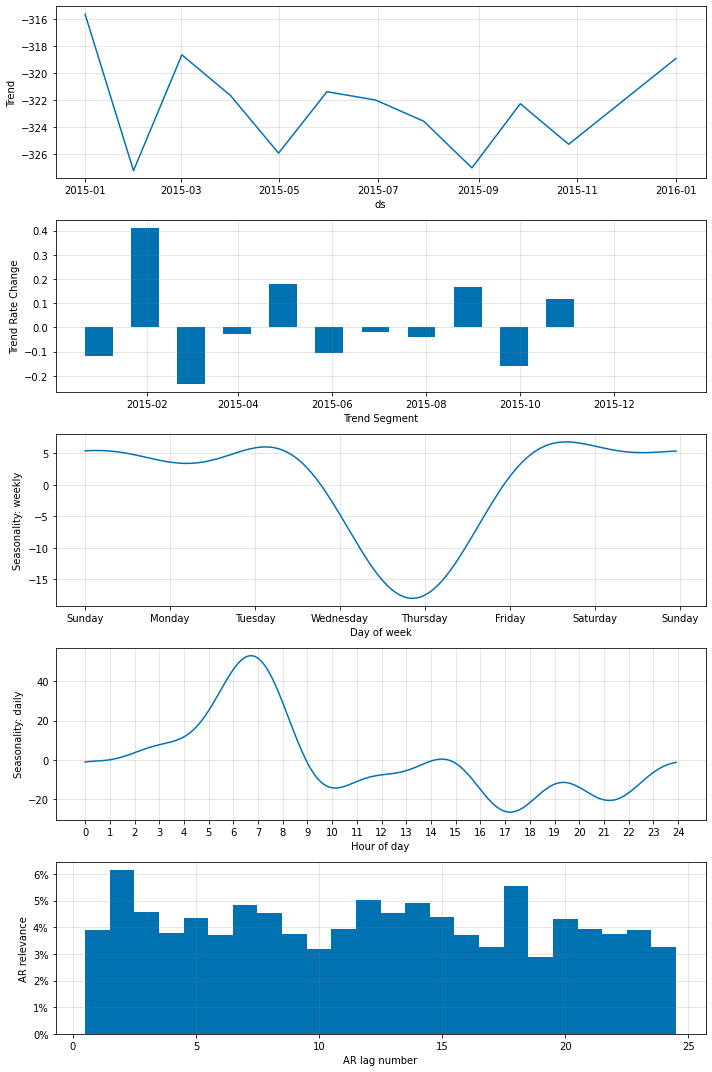

In [61]:
fig_param = m.plot_parameters()


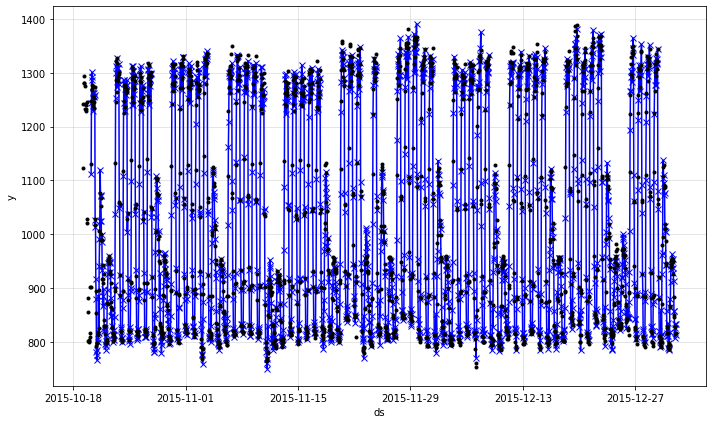

In [62]:
fig_fit = m.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)


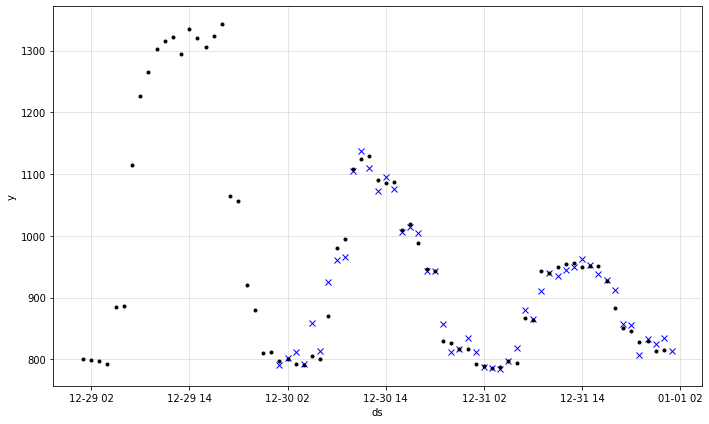

In [63]:
fig_prediction = m.plot_last_forecast(forecast, include_previous_forecasts=48)
